<a href="https://www.kaggle.com/code/fotimakhongulomova/task-2-policing-equity?scriptVersionId=142250021" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import os
import pandas as pd
import numpy as np
from datetime import date
import seaborn as sns
from scipy import stats

import matplotlib.pyplot as plt
import warnings

from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from sklearn.feature_selection import VarianceThreshold

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
warnings.filterwarnings('ignore')

## Constants

In [3]:
FILE = '/kaggle/input/data-science-for-good/Dept_11-00091/11-00091_Field-Interviews_2011-2015.csv'

## Load Data

In [4]:
data = pd.read_csv(FILE, low_memory=False)

df = pd.DataFrame(data)

df.drop([0], axis=0, inplace=True)
df.reset_index(drop=True, inplace=True)

df.head()

,INCIDENT_UNIQUE_IDENTIFIER,INCIDENT_UNIQUE_IDENTIFIER.1,SUBJECT_GENDER,LOCATION_FULL_STREET_ADDRESS_OR_INTERSECTION,LOCATION_DISTRICT,LOCATION_DISTRICT.1,INCIDENT_DATE,INCIDENT_TIME,SUBJECT_DETAILS,SUBJECT_RACE,...,VEHICLE_DETAILS.1,OFFICER_SUPERVISOR,OFFICER_ID,OFFICER_ASSIGNMENT,OFFICER_ASSIGNMENT.1,OFFICER_ETHNICITY,OFFICER_RACE,OFFICER_AGE,LOCATION_STREET_NUMBER,LOCATION_CITY
0,938283,621880,MALE,NORMANDY ST at SUPPLE RD,B2,3,12/10/13 0:00,12/10/13 0:00,YES,B(Black),...,MA,10132,98656,9999,OTHER,NaN,B(Black),59,3274,NO DATA ENTERED
1,881897,565177,MALE,75 BOYLSTON ST,A1,1,5/24/12 0:00,5/24/12 0:00,NO,W(White),...,NO DATA ENTERED,8949,9765,1,A1,NaN,W(White),26,543,OTHER
2,882060,565340,MALE,5 TOPLIFF ST,C11,5,6/4/12 0:00,6/4/12 0:00,YES,B(Black),...,NO DATA ENTERED,11312,83575,16,YVSF,NaN,B(Black),18,4493,NO DATA ENTERED
3,971623,653895,MALE,170 MORTON ST,B2,3,6/21/14 0:00,6/21/14 0:00,YES,B(Black),...,NO DATA ENTERED,9375,76146,25,BIKE,NaN,B(Black),24,3094,Dorchester
4,882761,566043,MALE,0 ST ALPHONSUS ST,B2,3,12/2/10 0:00,12/2/10 0:00,YES,B(Black),...,MA,NaN,107106,3,B2,NaN,B(Black),70,4241,Dorchester


# Step 1: Data Exploration and Preprocessing

In [5]:
print(f"\nThe shape of the data: {df.shape}\n")
print(f"The types of the data: \n{df.dtypes}\n")
print(f"The empty row in the data: \n{df.isnull().sum()}")


The shape of the data: (152230, 34)

The types of the data: 
INCIDENT_UNIQUE_IDENTIFIER                      object
INCIDENT_UNIQUE_IDENTIFIER.1                    object
SUBJECT_GENDER                                  object
LOCATION_FULL_STREET_ADDRESS_OR_INTERSECTION    object
LOCATION_DISTRICT                               object
LOCATION_DISTRICT.1                             object
INCIDENT_DATE                                   object
INCIDENT_TIME                                   object
SUBJECT_DETAILS                                 object
SUBJECT_RACE                                    object
SUBJECT_DETAILS.1                               object
SUBJECT_DETAILS.2                               object
UNKNOWN_FIELD_TYPE                              object
UNKNOWN_FIELD_TYPE.1                            object
SEARCH_CONDUCTED                                object
SEARCH_REASON                                   object
INCIDENT_REASON                                 object
INC

### Data Cleaning

In [6]:
# data cleaning
df.drop(["INCIDENT_UNIQUE_IDENTIFIER", 'INCIDENT_UNIQUE_IDENTIFIER.1', "UNKNOWN_FIELD_TYPE.1", 
         "INCIDENT_TIME", 'LOCATION_STREET_NUMBER', 'OFFICER_ID', "LOCATION_FULL_STREET_ADDRESS_OR_INTERSECTION", 
         "UNKNOWN_FIELD_TYPE", 'OFFICER_ASSIGNMENT', 'OFFICER_ASSIGNMENT.1', 'OFFICER_SUPERVISOR', 'SUBJECT_DETAILS.1'], axis=1, inplace=True)

for feature in df.columns:
    if df[feature].isnull().sum() > 90000:
        df.drop([feature], axis=1, inplace=True)

### Handling missing values in the dataframe

In [7]:
for feature in df.columns:
    df[feature].replace(to_replace=["NO DATA ENTERED"], value="UNKNOWN", inplace=True)
    df[feature].replace(to_replace=np.nan, value="UNKNOWN", inplace=True) 

In [8]:
print(f"The empty row in the data: \n{df.isnull().sum()}")

The empty row in the data: 
SUBJECT_GENDER         0
LOCATION_DISTRICT      0
LOCATION_DISTRICT.1    0
INCIDENT_DATE          0
SUBJECT_DETAILS        0
SUBJECT_RACE           0
SUBJECT_DETAILS.2      0
INCIDENT_REASON        0
INCIDENT_REASON.1      0
DISPOSITION            0
VEHICLE_MAKE           0
VEHICLE_YEAR           0
VEHICLE_COLOR          0
VEHICLE_DETAILS.1      0
OFFICER_RACE           0
OFFICER_AGE            0
LOCATION_CITY          0
dtype: int64


In [9]:
# Extracting dates

df['INCIDENT_DATE'] = pd.to_datetime(df.INCIDENT_DATE)
df["INCIDENT_YEAR"] = df["INCIDENT_DATE"].dt.year
df["INCIDENT_MONTH"] = df["INCIDENT_DATE"].dt.month
df["INCIDENT_WEEKDAY"] = df["INCIDENT_DATE"].dt.strftime('%w')
df['INCIDENT_DATE'] = df['INCIDENT_DATE'].astype(str)
df["INCIDENT_DATE"] = df.INCIDENT_DATE.str.split("-").map(lambda x: x[2])

In [10]:
df.head()

,SUBJECT_GENDER,LOCATION_DISTRICT,LOCATION_DISTRICT.1,INCIDENT_DATE,SUBJECT_DETAILS,SUBJECT_RACE,SUBJECT_DETAILS.2,INCIDENT_REASON,INCIDENT_REASON.1,DISPOSITION,VEHICLE_MAKE,VEHICLE_YEAR,VEHICLE_COLOR,VEHICLE_DETAILS.1,OFFICER_RACE,OFFICER_AGE,LOCATION_CITY,INCIDENT_YEAR,INCIDENT_MONTH,INCIDENT_WEEKDAY
0,MALE,B2,3,10,YES,B(Black),Med,INVESTIGATIVE,"DRUGS, INVESTIGATION",SFO,NISSAN,2012,SILVER,MA,B(Black),59,UNKNOWN,2013,12,2
1,MALE,A1,1,24,NO,W(White),Med,RADIO CALL,"DRUGS, POSSESSION",F,UNKNOWN,0,UNKNOWN,UNKNOWN,W(White),26,OTHER,2012,5,4
2,MALE,C11,5,04,YES,B(Black),Dark,OTHER (SPECIFY),"INVESTIGATE, PERSON",F,UNKNOWN,0,UNKNOWN,UNKNOWN,B(Black),18,UNKNOWN,2012,6,1
3,MALE,B2,3,21,YES,B(Black),Med,INVESTIGATIVE,ABDW,S,UNKNOWN,0,UNKNOWN,UNKNOWN,B(Black),24,Dorchester,2014,6,6
4,MALE,B2,3,02,YES,B(Black),Light,INVESTIGATIVE,VAL,F,SATURN,2001,RED,MA,B(Black),70,Dorchester,2010,12,4


In [11]:
df.shape

(152230, 20)

In [12]:
# replace weird ages 
df['OFFICER_AGE'] = df['OFFICER_AGE'].astype(int)
replace = df[(df['OFFICER_AGE'] < 18) | (df['OFFICER_AGE'] > 75)]['OFFICER_AGE'].tolist()
value = round(df[(df['OFFICER_AGE'] >= 18) | (df['OFFICER_AGE'] <= 75)]['OFFICER_AGE'].mean())
df['OFFICER_AGE'].replace(to_replace=replace, value=value, inplace=True)

In [13]:
df.head()

,SUBJECT_GENDER,LOCATION_DISTRICT,LOCATION_DISTRICT.1,INCIDENT_DATE,SUBJECT_DETAILS,SUBJECT_RACE,SUBJECT_DETAILS.2,INCIDENT_REASON,INCIDENT_REASON.1,DISPOSITION,VEHICLE_MAKE,VEHICLE_YEAR,VEHICLE_COLOR,VEHICLE_DETAILS.1,OFFICER_RACE,OFFICER_AGE,LOCATION_CITY,INCIDENT_YEAR,INCIDENT_MONTH,INCIDENT_WEEKDAY
0,MALE,B2,3,10,YES,B(Black),Med,INVESTIGATIVE,"DRUGS, INVESTIGATION",SFO,NISSAN,2012,SILVER,MA,B(Black),59,UNKNOWN,2013,12,2
1,MALE,A1,1,24,NO,W(White),Med,RADIO CALL,"DRUGS, POSSESSION",F,UNKNOWN,0,UNKNOWN,UNKNOWN,W(White),26,OTHER,2012,5,4
2,MALE,C11,5,04,YES,B(Black),Dark,OTHER (SPECIFY),"INVESTIGATE, PERSON",F,UNKNOWN,0,UNKNOWN,UNKNOWN,B(Black),18,UNKNOWN,2012,6,1
3,MALE,B2,3,21,YES,B(Black),Med,INVESTIGATIVE,ABDW,S,UNKNOWN,0,UNKNOWN,UNKNOWN,B(Black),24,Dorchester,2014,6,6
4,MALE,B2,3,02,YES,B(Black),Light,INVESTIGATIVE,VAL,F,SATURN,2001,RED,MA,B(Black),70,Dorchester,2010,12,4


### Reducing unique values in INCIDENT_REASON.1 column

In [14]:
# Find rows where 'INCIDENT_REASON.1' appears only once
unique_counts = df['INCIDENT_REASON.1'].value_counts()
unique_values = unique_counts[unique_counts == 1].index

for value in unique_values:
    df['INCIDENT_REASON.1'].replace(value, value='OTHER', inplace=True)

In [15]:
responses = df['INCIDENT_REASON.1'].unique()

categories = {
    'DRUGS': ['DRUGS', 'OVERDOSE'],
    'PROSTITUTION': ['PROSTITUTION'],
    'ALCOHOL': ['ALCOHOL', 'PUBLIC DRINKING'], 
    'ROBBERY': ['ROBBERY', 'LARCENY', 'STOLEN'], 
    'RAPE': ['RAPE'],
    'SEXUAL OFFENDER': ['SEXUAL OFFENDER', 'SEX OFFENDER'],
    'HIT & RUN': ['HIT & RUN'],
    'ACCIDENT': ['ACCIDENT'],
    'SEX-ASSAULT': ['SEX-ASSAULT'], 
    'MALICIOUS DESTRUCTION PROPERTY': ['MALICIOUS DESTRUCTION PROPERTY'],
    'HARASSMENT': ['HARASSMENT'],
    'INVESTIGATE': ['INVESTIGATE']
    
}

for response in responses:
    for key, values in categories.items():            
        if any(value in response for value in values):
            df['INCIDENT_REASON.1'].replace(response, value=key, inplace=True)                 
            break

In [16]:
len(df['INCIDENT_REASON.1'].value_counts())

133

# Step 2: Data Visualization

### Gender and Race Distribution

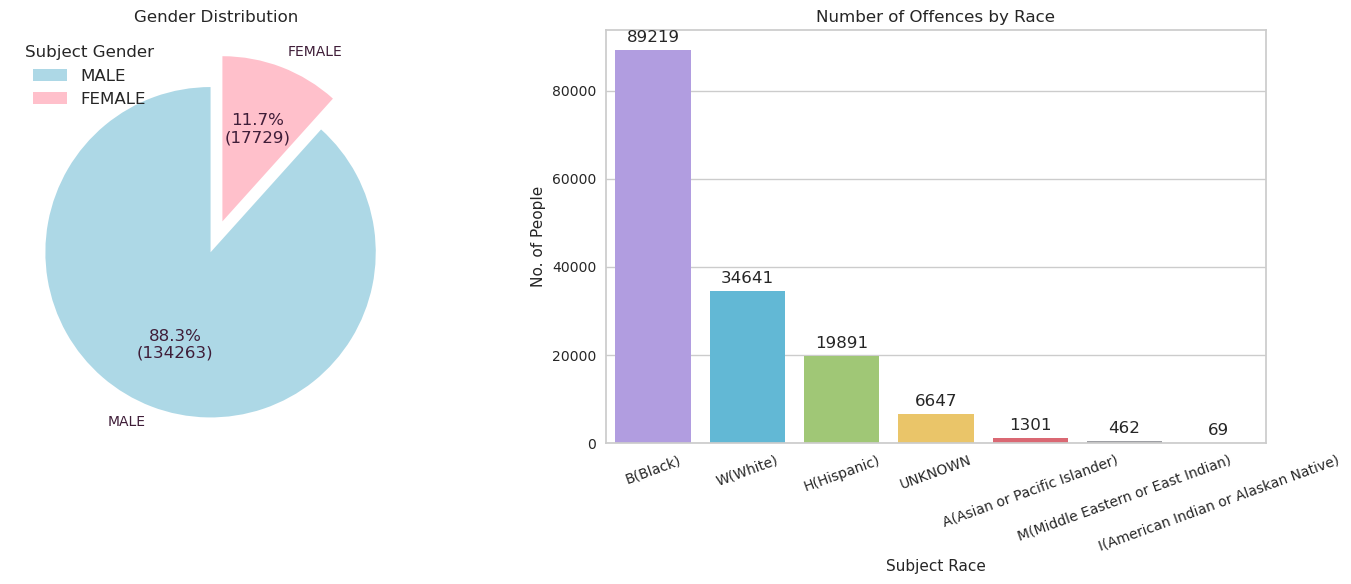

In [17]:
# Pie Chart
data = [len(df[df['SUBJECT_GENDER'] == feature]) for feature in df['SUBJECT_GENDER'].value_counts().index[0:2]]
labels = ['MALE', 'FEMALE']
colors = ['lightblue', 'pink']
explode = (0.1, 0.1)

# Creating autocpt arguments
def func(pct, allvalues):
    absolute = int(pct / 100.*np.sum(allvalues))
    return "{:.1f}%\n({:d})".format(pct, absolute)

plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.pie(data, labels=labels, explode=explode, colors=colors, 
        autopct=lambda pct: func(pct, data), startangle=90, textprops=dict(color ="#3F1D38"))
plt.rcParams.update({'font.size': 12})
plt.legend(labels, title="Subject Gender", fontsize="12")
plt.title("Gender Distribution")

# Bar Chart
plt.subplot(1, 2, 2)
order = df['SUBJECT_RACE'].value_counts().index
colors = ['#AC92EB', '#4FC1E8', '#A0D568', '#FFCE54', '#ED5564', '#9E9FA5']

ax = sns.countplot(x='SUBJECT_RACE', data=df, order=order, palette=colors)  # Pass 'x' and 'data' parameters
for label in ax.containers[0]:
    ax.annotate(format(int(label.get_height())), 
                (label.get_x() + label.get_width() / 2., label.get_height()), 
                ha='center', va='center', xytext=(0, 9), textcoords='offset points')

plt.xticks(rotation=20)
plt.title('Number of Offences by Race')
plt.xlabel('Subject Race')
plt.ylabel('No. of People')

# Show plots
plt.tight_layout()
plt.show()

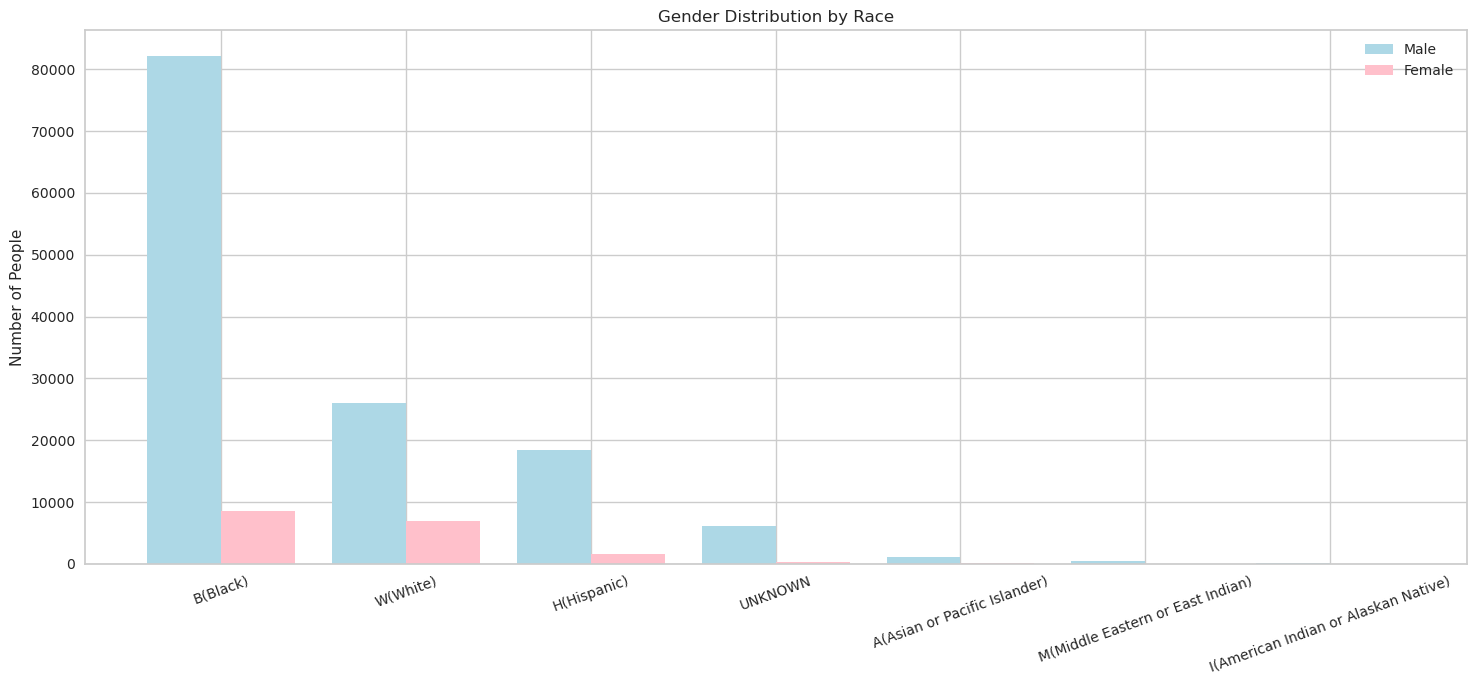

In [18]:
# Set the figure size
plt.figure(figsize=(15, 7))

# Extract the unique race categories to plot
race_to_plot = df['SUBJECT_RACE'].value_counts().keys()

# Filter data for male and female subjects
male = df[df['SUBJECT_GENDER'] == 'MALE']
female = df[df['SUBJECT_GENDER'] == 'FEMALE']

# Count the occurrences of gender and race combinations for male and female
values = [male['SUBJECT_RACE'].value_counts(), 
          female['SUBJECT_RACE'].value_counts()]

# Set up positions for the bars
x = np.arange(len(race_to_plot))
width = 0.4  # Width of the bars
colors = ['lightblue', 'pink']  # Colors for male and female bars

# Create the bar plots
plt.bar(x - width/2, values[0], width, color=colors[0], label='Male')
plt.bar(x + width/2, values[1], width, color=colors[1], label='Female')

# Set the x-axis labels and tick rotation
plt.xticks(x, race_to_plot, rotation=20)

# Set labels, legend, and title
plt.ylabel("Number of People")
plt.legend()
plt.title("Gender Distribution by Race")

# Display the plot
plt.tight_layout()  # Ensures that labels and titles are not cut off
plt.show()

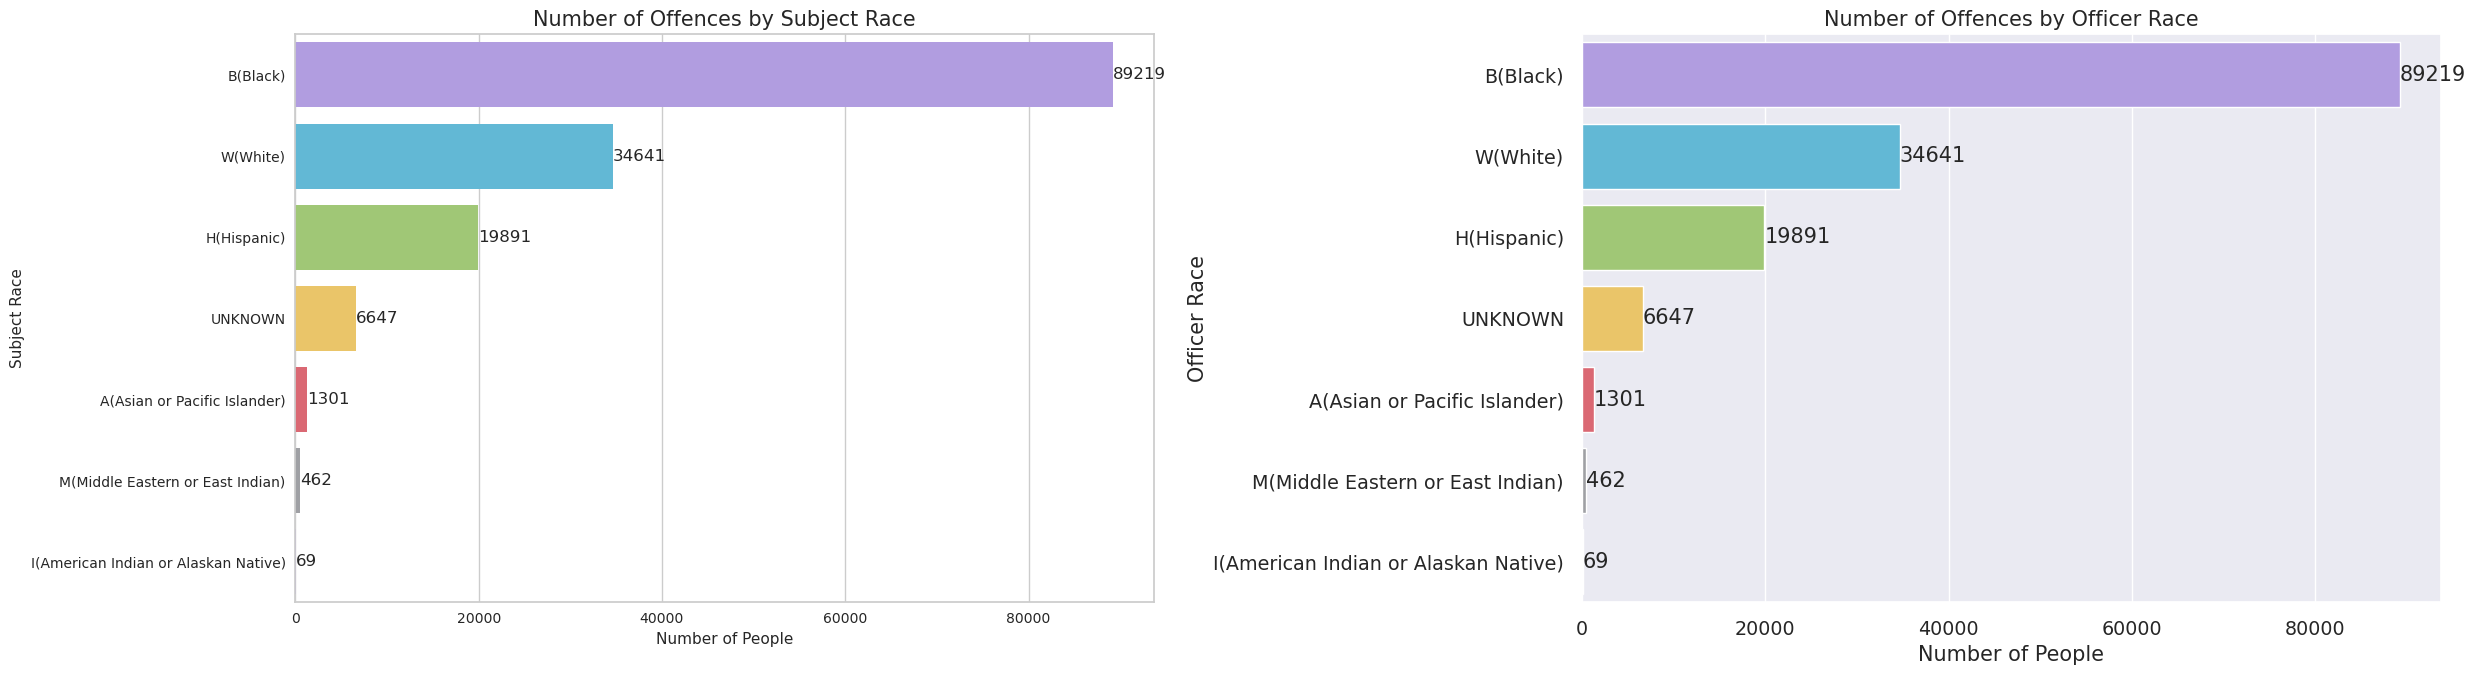

In [19]:
colors = ['#AC92EB', '#4FC1E8', '#A0D568', '#FFCE54', '#ED5564', '#9E9FA5']
plt.figure(figsize=(25, 7))

# Bar Chart - Subject Race
plt.subplot(1, 2, 1)
order_subject = df['SUBJECT_RACE'].value_counts().index

ax = sns.countplot(data=df, y='SUBJECT_RACE', order=order_subject, palette=colors)
for label in ax.containers:
    ax.bar_label(label)

sns.set(font_scale=1.25)
plt.title('Number of Offences by Subject Race')
plt.ylabel('Subject Race')
plt.xlabel('Number of People')


# Bar Chart - Officer Race
plt.subplot(1, 2, 2)
order_officer = df['OFFICER_RACE'].value_counts().index

ax = sns.countplot(data=df, y='OFFICER_RACE', order=order_officer, palette=colors)
for label in ax.containers:
    ax.bar_label(label)

sns.set(font_scale=1.25)
plt.title('Number of Offences by Officer Race')
plt.ylabel('Officer Race')
plt.xlabel('Number of People')

# Show plots
plt.tight_layout() 
plt.show()

### Number of offences distrubuted by Year and Months

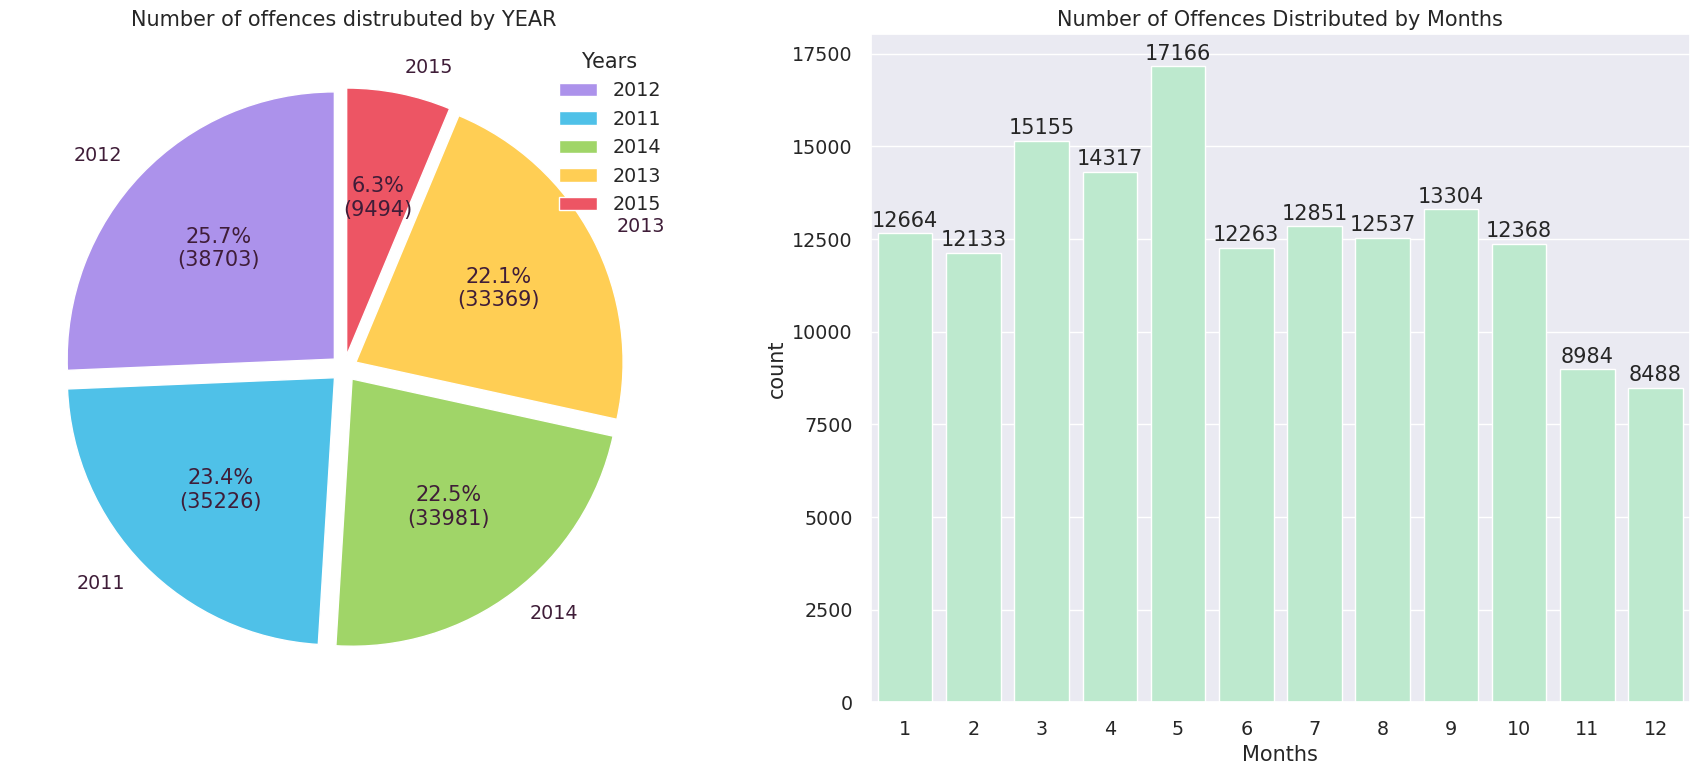

In [20]:
# Pie Chart

# Creating data
data = [len(df[df['INCIDENT_YEAR'] == feature]) for feature in df['INCIDENT_YEAR'].value_counts().index[0:5]]
labels = df['INCIDENT_YEAR'].value_counts().index[0:5]

colors = ['#AC92EB', '#4FC1E8', '#A0D568', '#FFCE54', '#ED5564'] # creating color parameters
explode = (0.05, 0.05, 0.05, 0.05, 0.05) # creating explode data

# Creating autocpt arguments
def func(pct, allvalues):
    absolute = int(pct / 100.*np.sum(allvalues))
    return "{:.1f}%\n({:d})".format(pct, absolute)

# Creating plot
plt.figure(figsize=(18, 8))
plt.subplot(1, 2, 1)
plt.pie(data, labels=labels, explode=explode, colors=colors, 
                                  autopct=lambda pct: func(pct, data), startangle=90, textprops=dict(color ="#3F1D38"))

# Adding legend
plt.legend(labels, title ="Years", loc ='best',)

plt.title("Number of offences distrubuted by YEAR")

# Bat chart
color=['#B5F1CC']
plt.subplot(1, 2, 2)
order = df['INCIDENT_MONTH'].value_counts().sort_index().index
ax = sns.countplot(x='INCIDENT_MONTH', data=df, order=order, palette=color)
for label in ax.containers[0]:
    ax.annotate(format(int(label.get_height())), 
                (label.get_x() + label.get_width() / 2., label.get_height()), 
                ha='center', va='center', xytext=(0, 9), textcoords='offset points')
    
plt.title('Number of Offences Distributed by Months')
plt.xlabel('Months')

plt.tight_layout() 
plt.show()

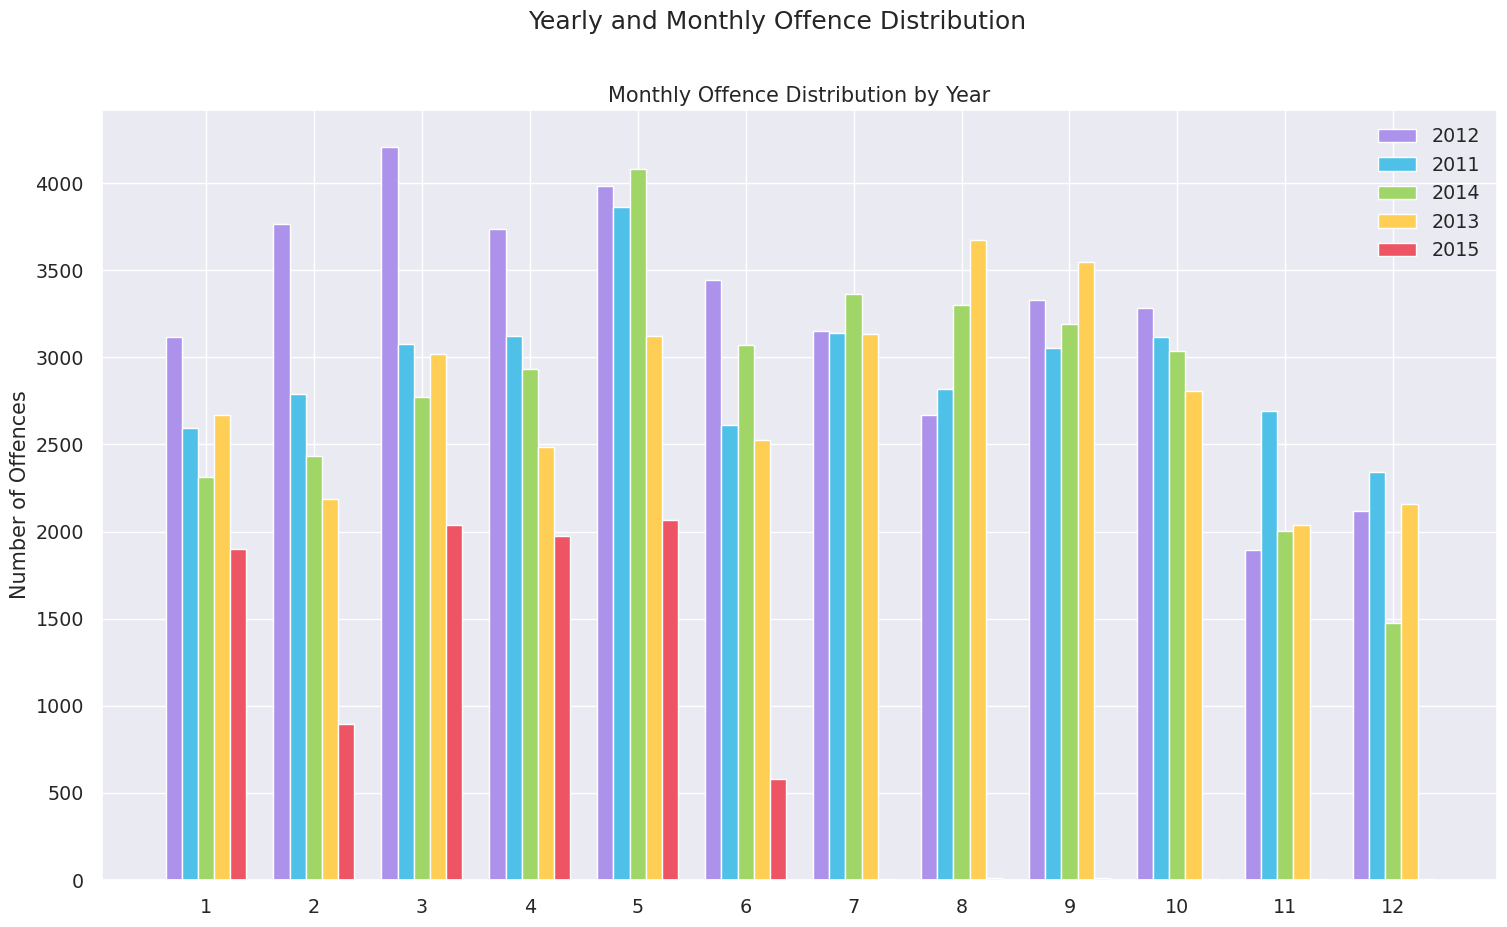

In [21]:
years_to_plot = df['INCIDENT_YEAR'].value_counts().index[:5]
values = []

for year in years_to_plot:
    c = df[df['INCIDENT_YEAR'] == year]
    value = c['INCIDENT_MONTH'].value_counts().sort_index()
    values.append(value)

x = np.arange(1, 13)
width = 0.15
colors = ['#AC92EB', '#4FC1E8', '#A0D568', '#FFCE54', '#ED5564']

plt.figure(figsize=(18, 10))
for n in range(5):
    plt.bar(x + (n - 2) * width, values[n], width=width, color=colors[n])

plt.xticks(x, [str(i) for i in range(1, 13)])
plt.ylabel("Number of Offences")
plt.legend(df['INCIDENT_YEAR'].value_counts().index[:5])
plt.title("Monthly Offence Distribution by Year")

# Adding overall title to the entire figure
plt.suptitle("Yearly and Monthly Offence Distribution")

# Show plots
plt.show()

### Number of offences distrubuted by Date and Weekdays

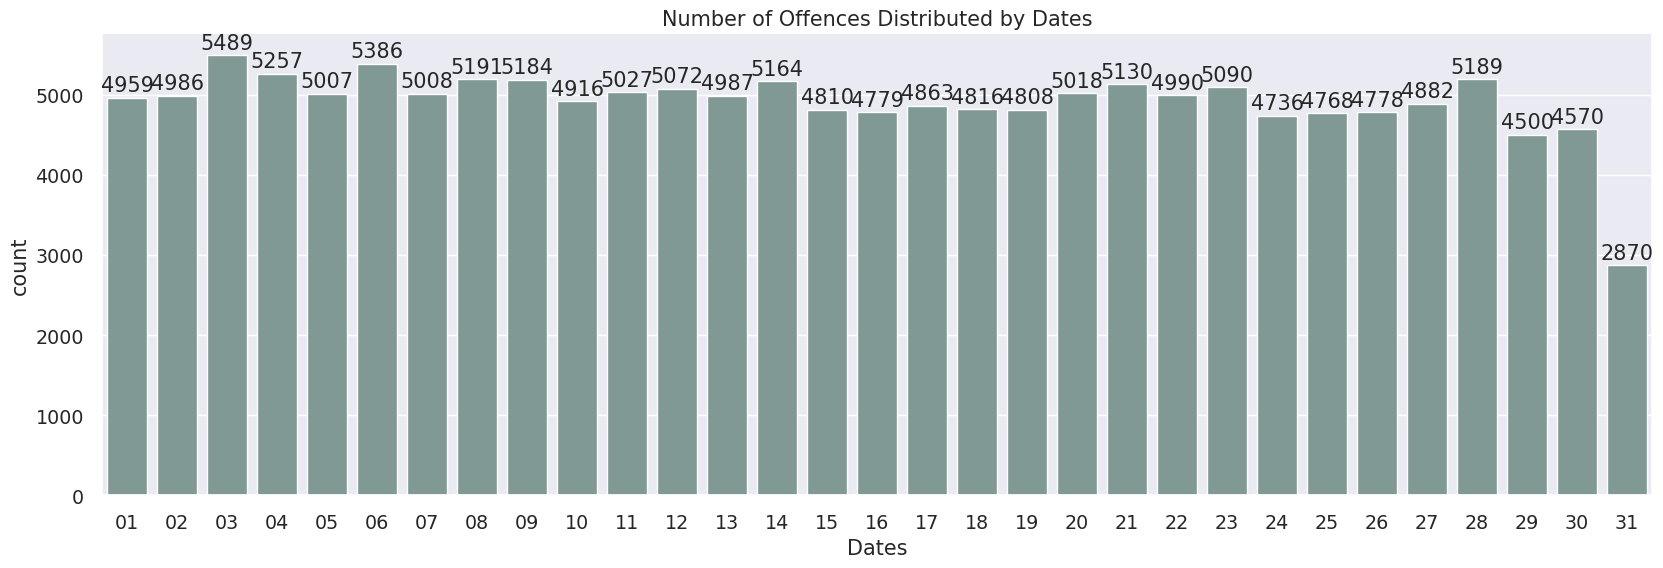

In [22]:
plt.figure(figsize=(20, 6))

# Bar chart for dates
order = df['INCIDENT_DATE'].value_counts().sort_index().index
ax = sns.countplot(x='INCIDENT_DATE',data=df, order=order, color='#7C9D96')

for label in ax.containers[0]:
    ax.annotate(format(int(label.get_height())), 
                (label.get_x() + label.get_width() / 2., label.get_height()), 
                ha='center', va='center', xytext=(0, 9), textcoords='offset points')

plt.title('Number of Offences Distributed by Dates')
plt.xlabel('Dates')
sns.set(font_scale=1.25)

plt.show()

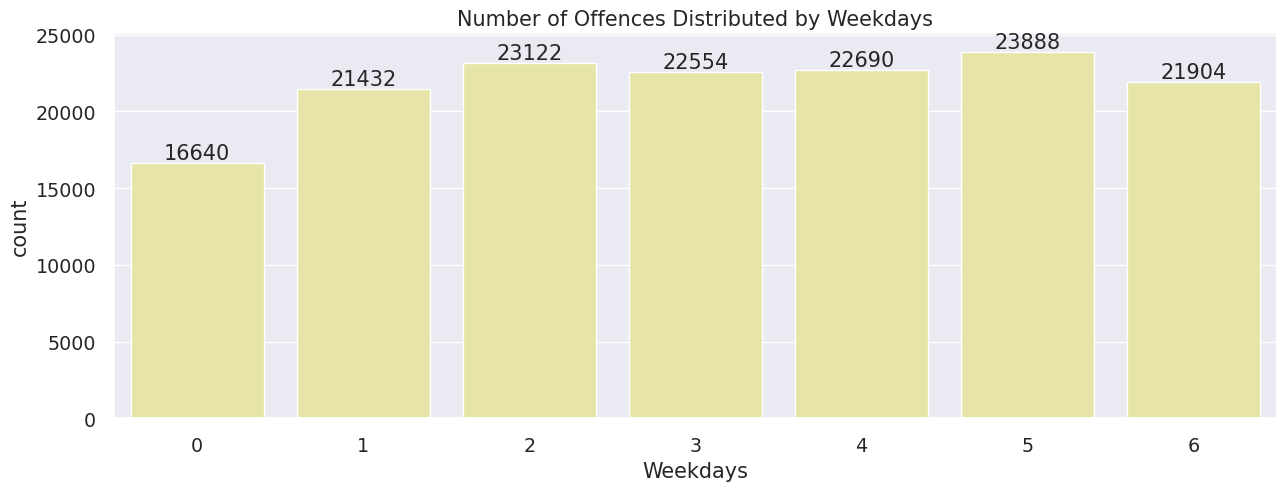

In [23]:
# Bar chart for weekdays
plt.figure(figsize=(15, 5))
order = df['INCIDENT_WEEKDAY'].value_counts().sort_index().index
ax = sns.countplot(x='INCIDENT_WEEKDAY', data=df, order=order, color='#F2EE9D')

for label in ax.containers:
    ax.bar_label(label)
    
plt.title('Number of Offences Distributed by Weekdays')
plt.xlabel('Weekdays')

plt.show()

### Number of offences distrubuted by crimes

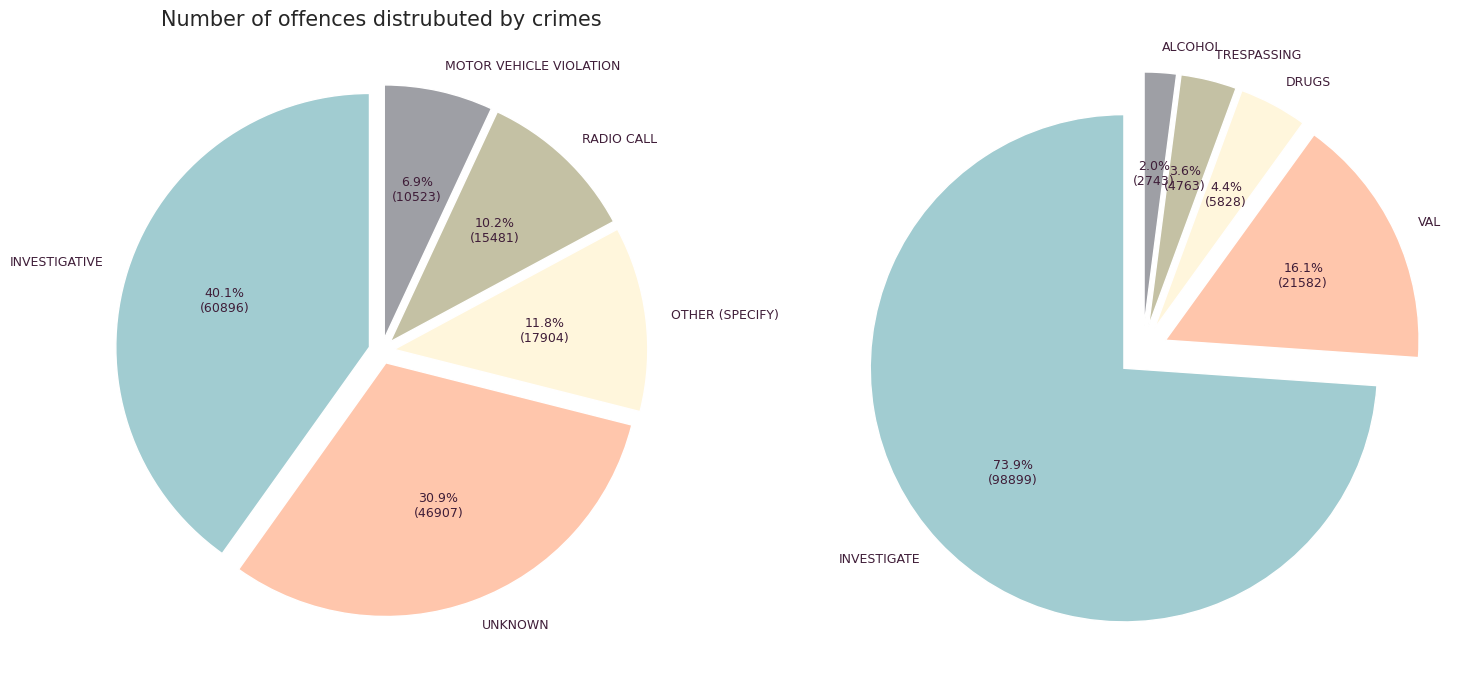

In [24]:
# Creating data
data = [len(df[df['INCIDENT_REASON'] == feature]) for feature in df['INCIDENT_REASON'].value_counts().index[0:5]]
labels = df['INCIDENT_REASON'].value_counts().index[0:5].tolist()

colors = ['#A1CCD1', '#FFC6AC', '#FFF6DC', '#C4C1A4', '#9E9FA5'] # creating color parameters
explode = (0.05, 0.05, 0.05, 0.05, 0.05) # creating explode data

# Creating autocpt arguments
def func(pct, allvalues):
    absolute = int(pct / 100.*np.sum(allvalues))
    return "{:.1f}%\n({:d})".format(pct, absolute)

# Creating plot
plt.figure(figsize=(18, 10))
plt.subplot(1, 2, 1)
plt.pie(data, explode=explode, colors=colors, labels=labels,
        autopct=lambda pct: func(pct, data), startangle=90, textprops={'color': "#3F1D38", 'fontsize': 9})
plt.title("Number of offences distrubuted by crimes")

# Adding legend
# plt.legend(labels, title ="Type of crimes",
#           loc ="center left",
#           bbox_to_anchor =(1, 0.1, 0.5, 0.5))


data1 = [len(df[df['INCIDENT_REASON.1'] == feature]) for feature in df['INCIDENT_REASON.1'].value_counts().index[0:5]]
labels1 = df['INCIDENT_REASON.1'].value_counts().index[0:5].tolist()

colors = ['#A1CCD1', '#FFC6AC', '#FFF6DC', '#C4C1A4', '#9E9FA5'] # creating color parameters
explode = (0.1, 0.1, 0.1, 0.1, 0.1) # creating explode data

# Creating autocpt arguments
def func(pct, allvalues):
    absolute = int(pct / 100.*np.sum(allvalues))
    return "{:.1f}%\n({:d})".format(pct, absolute)

# Creating plot
plt.subplot(1, 2, 2)
plt.pie(data1, explode=explode, colors=colors, labels=labels1,
        autopct=lambda pct: func(pct, data1), startangle=90, textprops={'color': "#3F1D38", 'fontsize': 9})

# Adding legend
# plt.legend(labels1, title ="Type of crimes",
#           loc ="center left",
#           bbox_to_anchor =(1, 0.1, 0.5, 0.5))

plt.show()

### Number of offences distrubuted by Officer Age

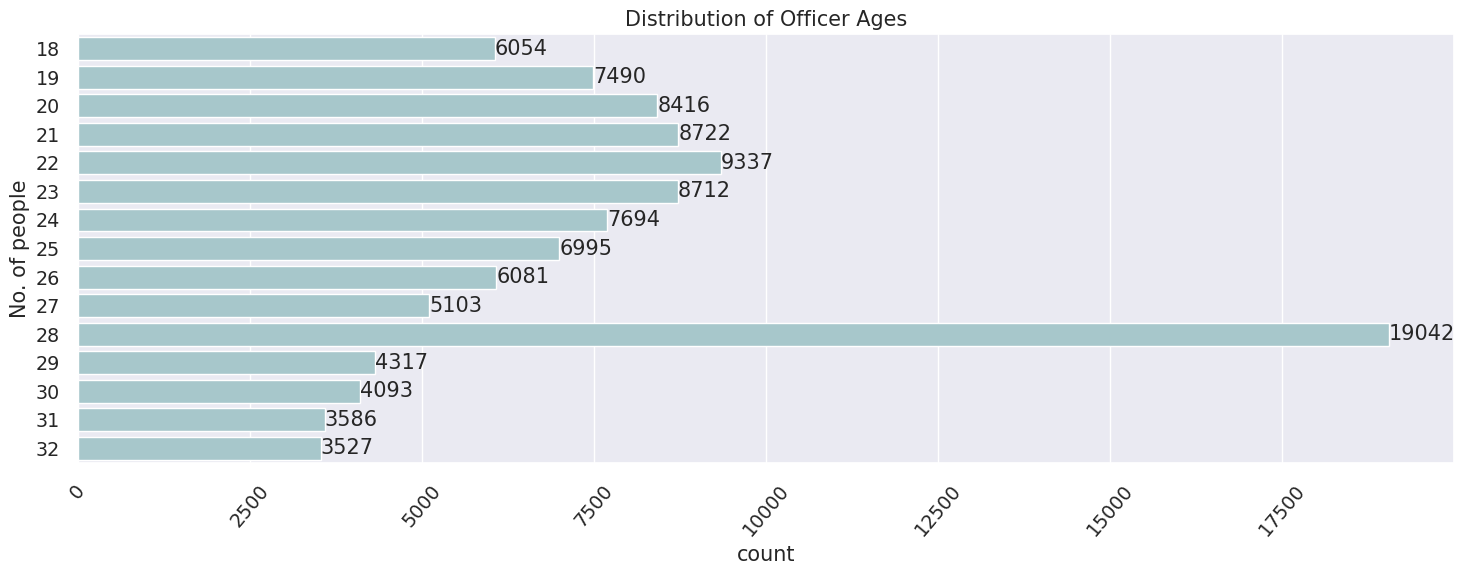

In [25]:
# Bar Chart
order = df['OFFICER_AGE'].value_counts().index[:15].sort_values()
plt.figure(figsize=(15, 6))

ax = sns.countplot(y='OFFICER_AGE', data=df, order=order, color='#A1CCD1')
for label in ax.containers:
    ax.bar_label(label)

plt.xticks(rotation=50)
plt.title('Distribution of Officer Ages')
plt.ylabel('Age')
plt.ylabel('No. of people')

# Show plots
plt.tight_layout() 
plt.show()

### Number of offences distrubuted by location

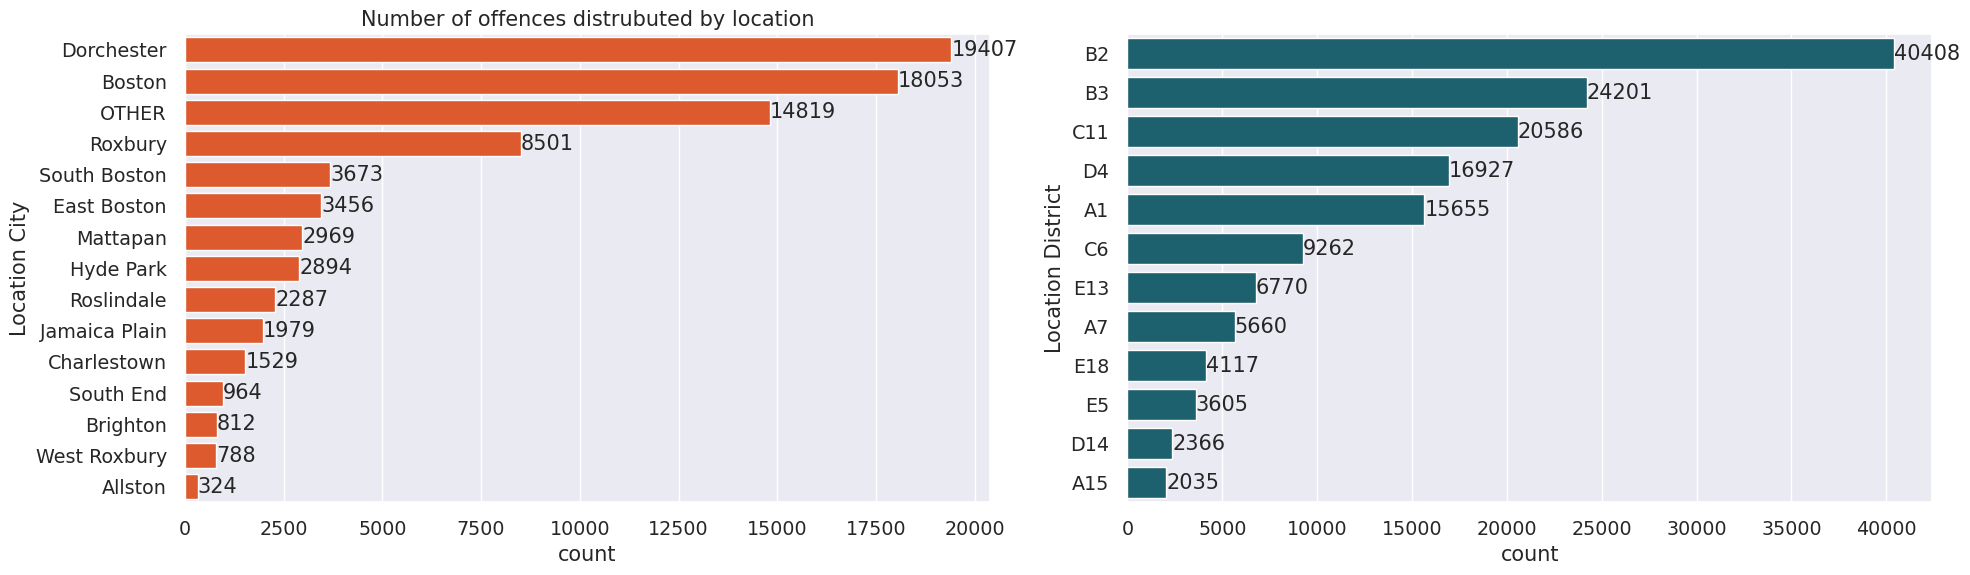

In [26]:
# Bar chart 1: Location city
plt.figure(figsize=(20, 6))
plt.subplot(1, 2, 1)
order = df['LOCATION_CITY'].value_counts().index[1:16]
ax = sns.countplot(y=df['LOCATION_CITY'], order=order, color='#F94C10')

for label in ax.containers:
    ax.bar_label(label)

plt.title('Number of offences distrubuted by location')
plt.ylabel('Location City')

# Bar chart 2: Location district
plt.subplot(1, 2, 2)
order = df['LOCATION_DISTRICT'].value_counts().index[:12]
ax = sns.countplot(y=df['LOCATION_DISTRICT'], order=order, color='#116A7B')

for label in ax.containers:
    ax.bar_label(label)

plt.ylabel('Location District')

plt.tight_layout() 
plt.show()

### Subject Details

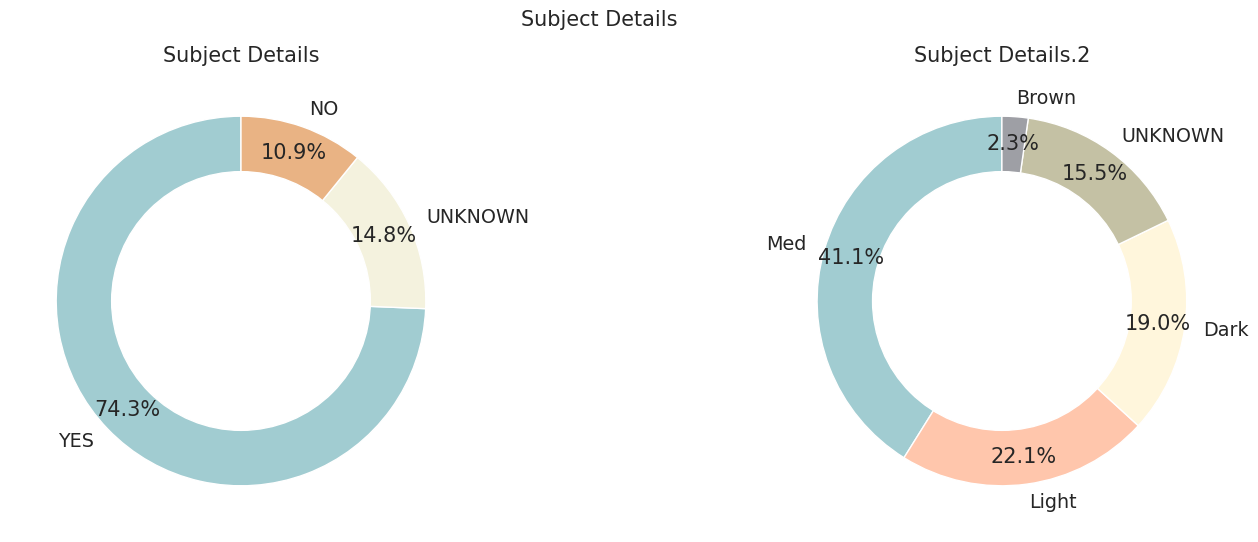

In [27]:
# Creating data
data1 = [len(df[df['SUBJECT_DETAILS'] == feature]) for feature in df['SUBJECT_DETAILS'].value_counts().index]
labels1 = df['SUBJECT_DETAILS'].value_counts().index

# Colors
colors = ['#A1CCD1', '#F4F2DE', '#E9B384'] # creating color parameters
colors1 = ['#A1CCD1', '#FFC6AC', '#FFF6DC', '#C4C1A4', '#9E9FA5'] # creating color parameters

fig, axs = plt.subplots(1, 2, figsize=(18, 6))  # 1 row, 3 columns of subplots
plt.suptitle('Subject Details', fontsize=15)

# First Pie: Subject Details
axs[0].pie(data1, colors=colors, labels=labels1, autopct='%1.1f%%', startangle=90, pctdistance=0.85)
centre_circle1 = plt.Circle((0,0),0.70,fc='white')
axs[0].add_artist(centre_circle1)
axs[0].set_title("Subject Details")

# Second Pie Chart: Subject Details.2
data3 = [len(df[df['SUBJECT_DETAILS.2'] == feature]) for feature in df['SUBJECT_DETAILS.2'].value_counts().index[0:5]]
labels3 = df['SUBJECT_DETAILS.2'].value_counts().index[0:5]

axs[1].pie(data3, colors=colors1, labels=labels3, autopct='%1.1f%%', startangle=90, pctdistance=0.85)
centre_circle3 = plt.Circle((0,0),0.70,fc='white')
axs[1].add_artist(centre_circle3)
axs[1].set_title("Subject Details.2")

plt.show()

### Vehicle Details

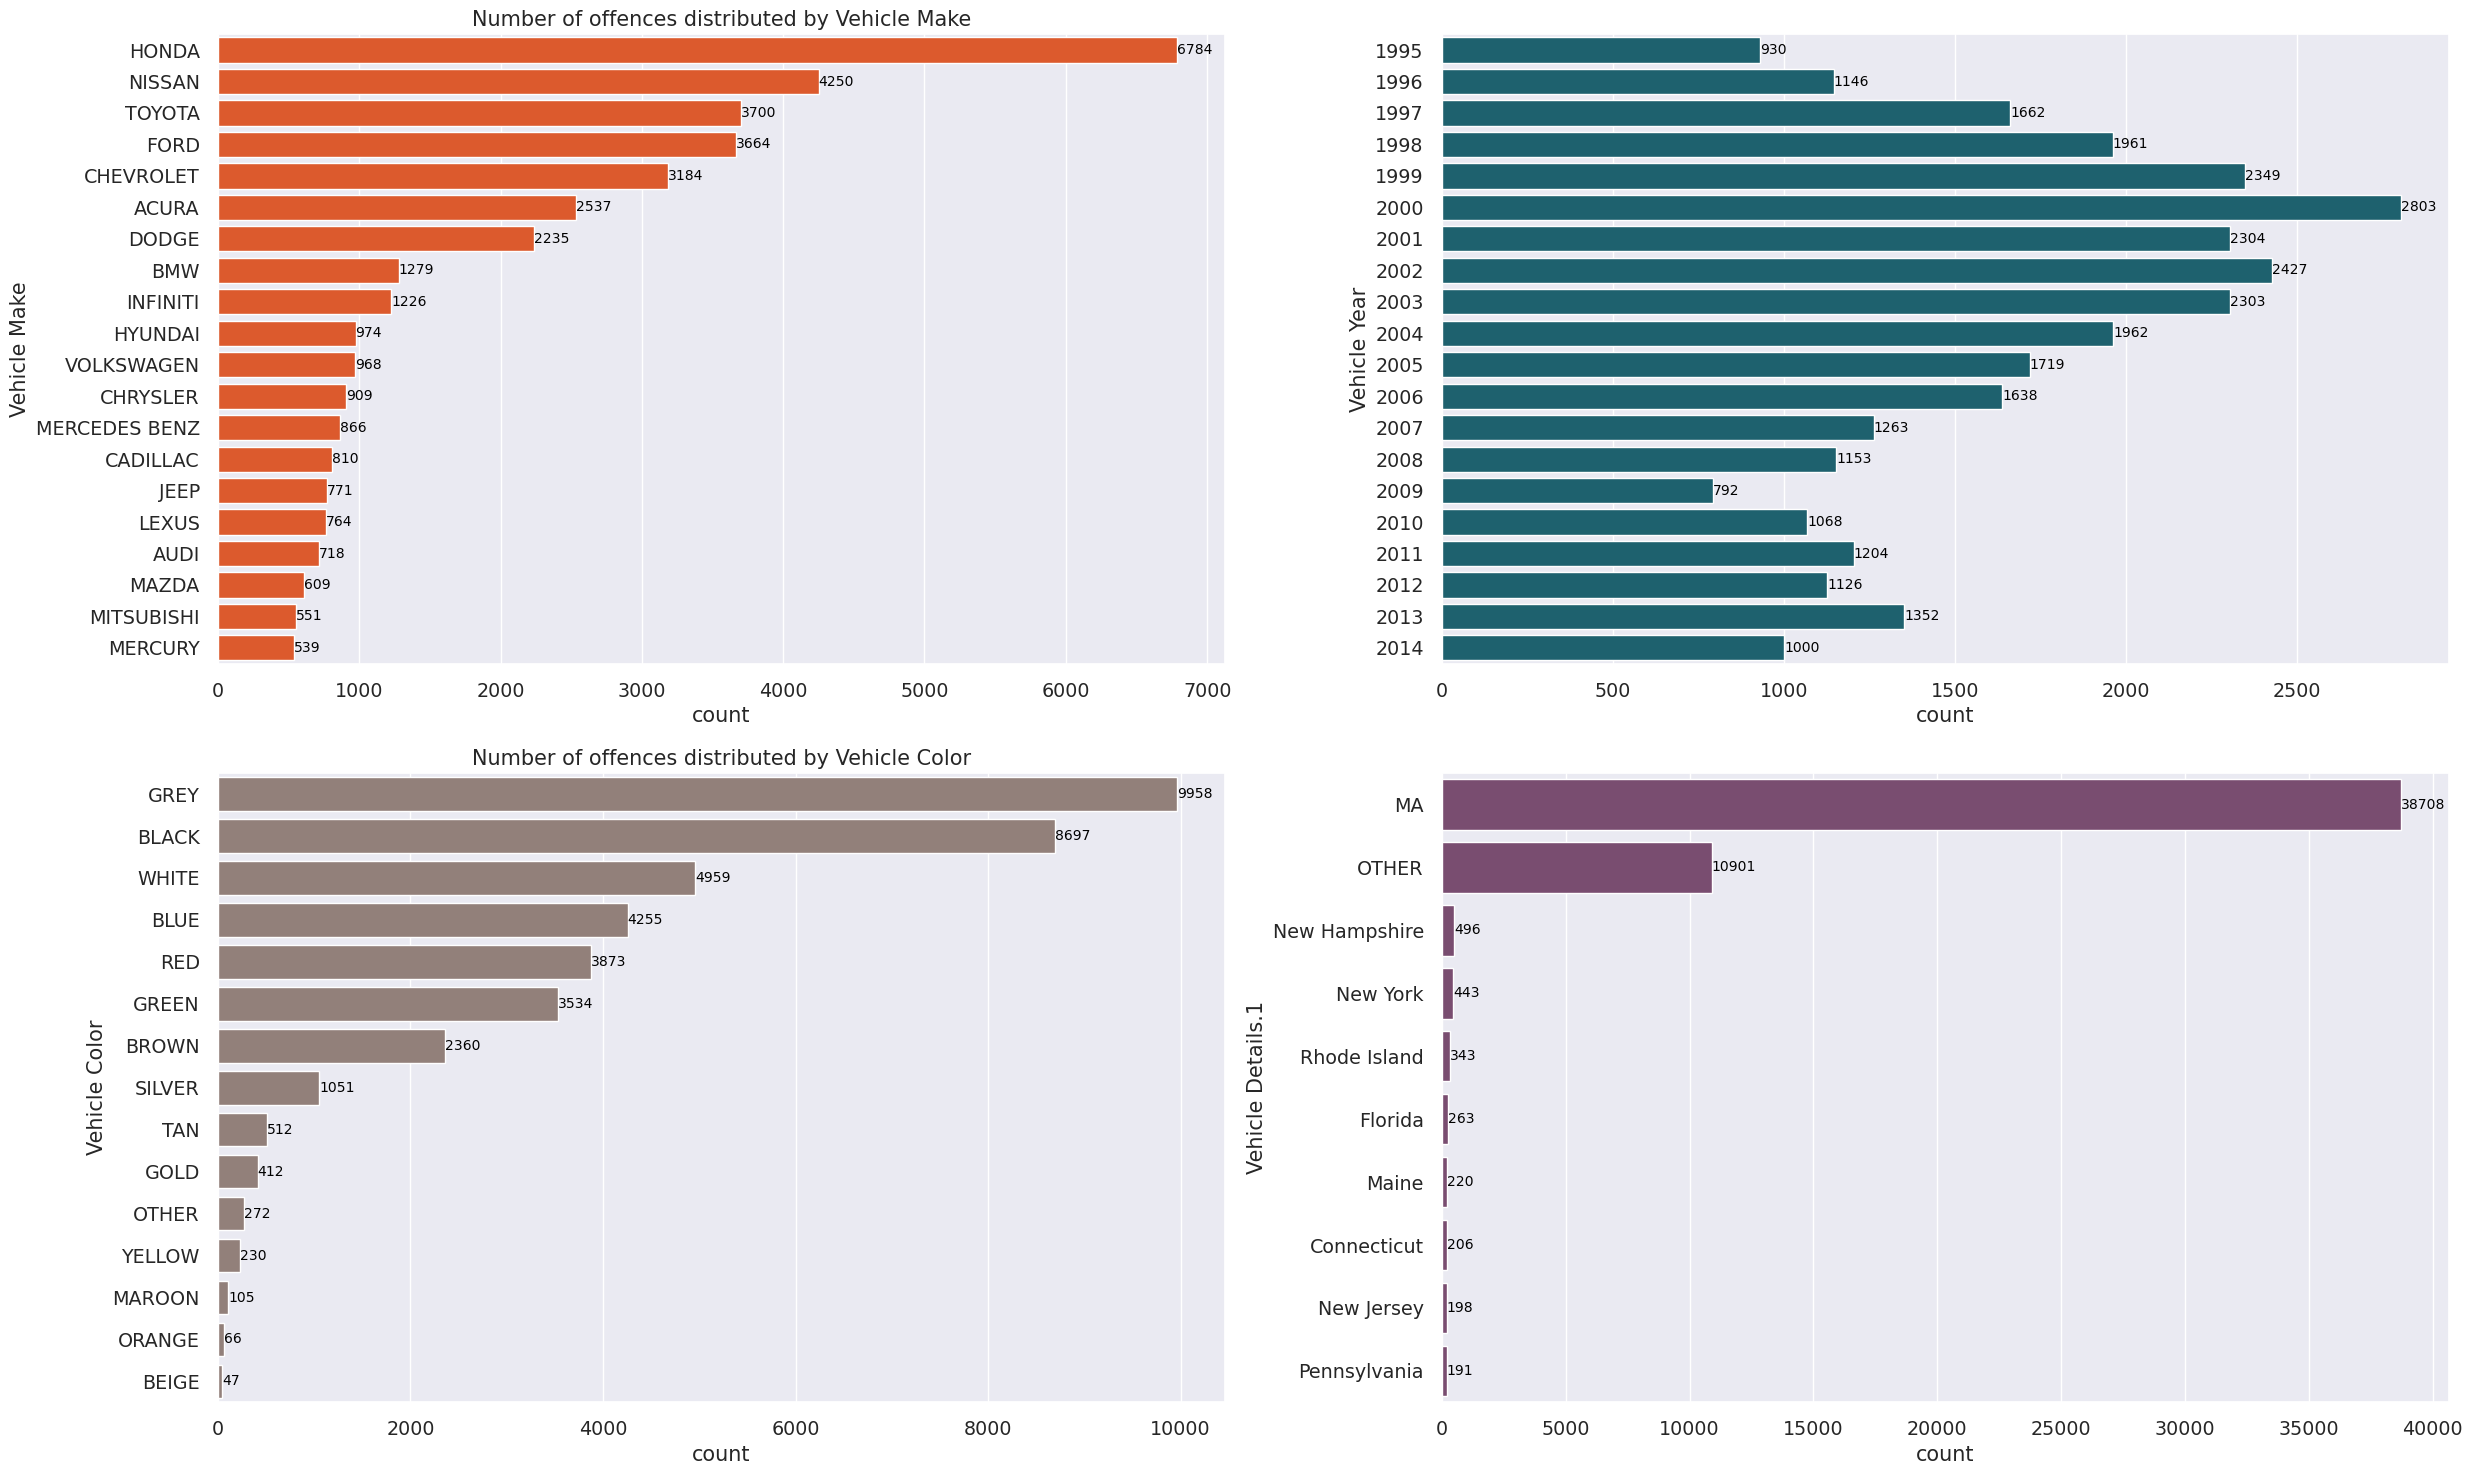

In [28]:
plt.figure(figsize=(25, 15))

# Bar chart 1: Vehicle Make
plt.subplot(2, 2, 1)
order = df["VEHICLE_MAKE"].value_counts().index[1:21]
ax = sns.countplot(y=df['VEHICLE_MAKE'], order=order, color='#F94C10')
for label in ax.containers:
    ax.bar_label(label, label_type='edge', fontsize=10, color='black')  # Adding labels to the bars
plt.title('Number of offences distributed by Vehicle Make')
plt.ylabel('Vehicle Make')

# Bar chart 2: Vehicle Year
plt.subplot(2, 2, 2)
order = df["VEHICLE_YEAR"].value_counts().sort_index().index[27:47]
ax = sns.countplot(y=df['VEHICLE_YEAR'], order=order, color='#116A7B')
for label in ax.containers:
    ax.bar_label(label, label_type='edge', fontsize=10, color='black')  # Adding labels to the bars
plt.ylabel('Vehicle Year')

# Bar chart 3: Vehicle Color
plt.subplot(2, 2, 3)  # Using the correct subplot indices
order = df["VEHICLE_COLOR"].value_counts().index[1:16]
ax = sns.countplot(y=df['VEHICLE_COLOR'], order=order, color='#967E76')
for label in ax.containers:
    ax.bar_label(label, label_type='edge', fontsize=10, color='black')  # Adding labels to the bars
plt.title('Number of offences distributed by Vehicle Color')
plt.ylabel('Vehicle Color')

# Bar chart 4: Vehicle Details.1
plt.subplot(2, 2, 4)  # Using the correct subplot indices
order = df["VEHICLE_DETAILS.1"].value_counts().index[1:11]
ax = sns.countplot(y=df['VEHICLE_DETAILS.1'], order=order, color='#804674')
for label in ax.containers:
    ax.bar_label(label, label_type='edge', fontsize=10, color='black')  # Adding labels to the bars
plt.ylabel('Vehicle Details.1')

plt.tight_layout()  # Adjust layout for better spacing
plt.show()

In [29]:
df['VEHICLE_YEAR'] = df['VEHICLE_YEAR'].astype(str)
df['INCIDENT_YEAR'] = df['INCIDENT_YEAR'].astype(str)

# Step 3: Feature Engineering

In [30]:
# Label encoding
categorical_features = df.select_dtypes(include=['object', 'category'])

for feature in categorical_features:
    le = LabelEncoder()
    df[feature] = le.fit_transform(df[feature])
    
df.head()

,SUBJECT_GENDER,LOCATION_DISTRICT,LOCATION_DISTRICT.1,INCIDENT_DATE,SUBJECT_DETAILS,SUBJECT_RACE,SUBJECT_DETAILS.2,INCIDENT_REASON,INCIDENT_REASON.1,DISPOSITION,VEHICLE_MAKE,VEHICLE_YEAR,VEHICLE_COLOR,VEHICLE_DETAILS.1,OFFICER_RACE,OFFICER_AGE,LOCATION_CITY,INCIDENT_YEAR,INCIDENT_MONTH,INCIDENT_WEEKDAY
0,1,4,16,9,2,1,5,2,61,5,32,44,11,18,1,59,21,27,12,2
1,1,0,0,23,0,6,5,5,61,0,43,0,13,41,6,26,16,26,5,4
2,1,8,18,3,2,1,2,4,85,0,43,0,13,41,1,18,21,26,6,1
3,1,4,16,20,2,1,5,2,20,3,43,0,13,41,1,24,7,28,6,6
4,1,4,16,1,2,1,4,2,123,0,39,33,10,18,1,70,7,24,12,4


In [31]:
df.shape

(152230, 20)

In [32]:
numerical_feature = df.select_dtypes(include=['int64'])

for feature in numerical_feature:
    df[feature] = df[feature].astype('uint8')

# Step 4: Dimensionality Reduction

### Principal Component Analysis

In [33]:
scaled_data = StandardScaler().fit_transform(df)
pca = PCA().fit(scaled_data)
pca.explained_variance_

array([3.54271501e+00, 2.32720347e+00, 1.60765332e+00, 1.19223746e+00,
       1.10968044e+00, 1.05019512e+00, 1.01098952e+00, 9.99271514e-01,
       9.60376984e-01, 9.13740006e-01, 8.81929112e-01, 8.31361166e-01,
       8.13172478e-01, 7.41553201e-01, 6.84521137e-01, 5.31217103e-01,
       3.54673339e-01, 2.76714634e-01, 1.70926367e-01, 5.07460208e-31])

In [34]:
var_exp = pca.explained_variance_ratio_ * 100
print(np.round_(var_exp, decimals = 5))

[17.71346 11.63594  8.03821  5.96115  5.54837  5.25094  5.05491  4.99632
  4.80185  4.56867  4.40962  4.15678  4.06584  3.70774  3.42258  2.65607
  1.77336  1.38356  0.85463  0.     ]


In [35]:
cum_var_exp = np.cumsum(var_exp)
print(cum_var_exp)

[ 17.71345869  29.34939959  37.38761341  43.34876157  48.8971273
  54.14806841  59.2029828   64.19930754  69.00116092  73.56983094
  77.97944753  82.13622605  86.20206173  89.90980338  93.33238658
  95.98845465  97.7618097   99.14537378 100.         100.        ]


In [36]:
# extract the Eigenvectors
eig_vecs = pca.components_
eig_vecs

array([[ 4.28453411e-02,  4.99267238e-02,  1.41256548e-01,
        -7.23791906e-04,  5.04357296e-02, -1.69119215e-01,
        -4.29019492e-02,  8.86445270e-02,  2.48845734e-01,
        -1.33483796e-01, -4.38733596e-01,  4.49993245e-01,
        -4.30171690e-01, -4.68949088e-01, -1.69119215e-01,
        -8.76547178e-02,  1.30762552e-01,  3.81881978e-02,
        -1.39702780e-02,  1.23697424e-02],
       [-1.92833392e-01, -1.10623503e-01, -2.74424209e-01,
        -7.01901150e-03, -1.48098123e-01,  5.33952890e-01,
         2.10974615e-01, -4.36304342e-02,  6.49431158e-02,
         2.14432379e-01, -1.64748228e-01,  1.77855576e-01,
        -1.65244173e-01, -1.73587260e-01,  5.33952890e-01,
         1.77393984e-01, -1.89422251e-01,  2.32393654e-02,
        -4.84266115e-02, -3.90435465e-03],
       [ 1.26814372e-01, -4.93310701e-01, -4.34825996e-01,
        -1.73025043e-02, -1.17541481e-01, -3.08586681e-01,
        -3.55656050e-02, -3.27714855e-01,  5.28903796e-02,
         4.15517092e-01, -5.3

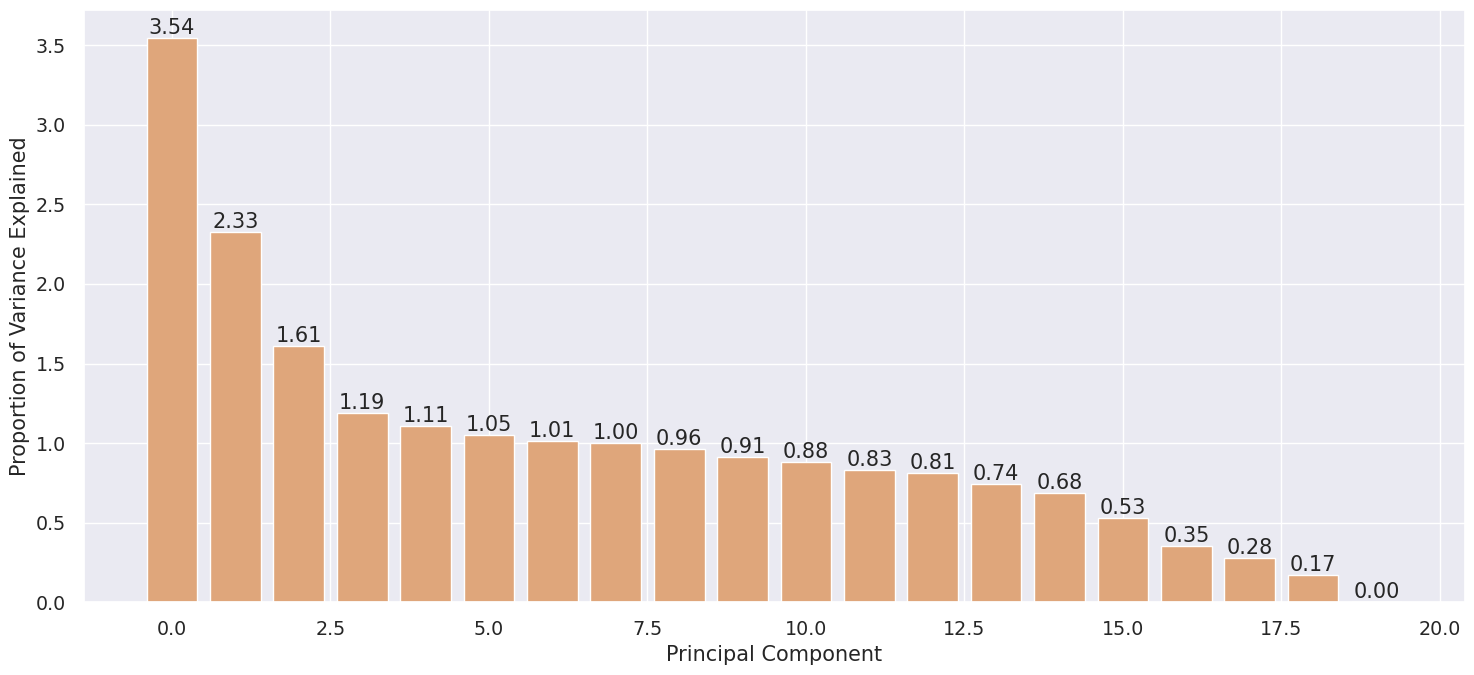

In [37]:
var = pca.explained_variance_ 
labels = list(range(0, len(var)))  # Creating labels for each principal component

plt.figure(figsize=(15, 7))

# Creating the bar plot
ax = plt.bar(labels, var, color="#DFA67B")

# Adding labels on top of each bar
for index, value in enumerate(var):
    plt.text(index, value, f"{value:.2f}", ha='center', va='bottom')

plt.xlabel('Principal Component')
plt.ylabel('Proportion of Variance Explained')

plt.tight_layout()
plt.show()

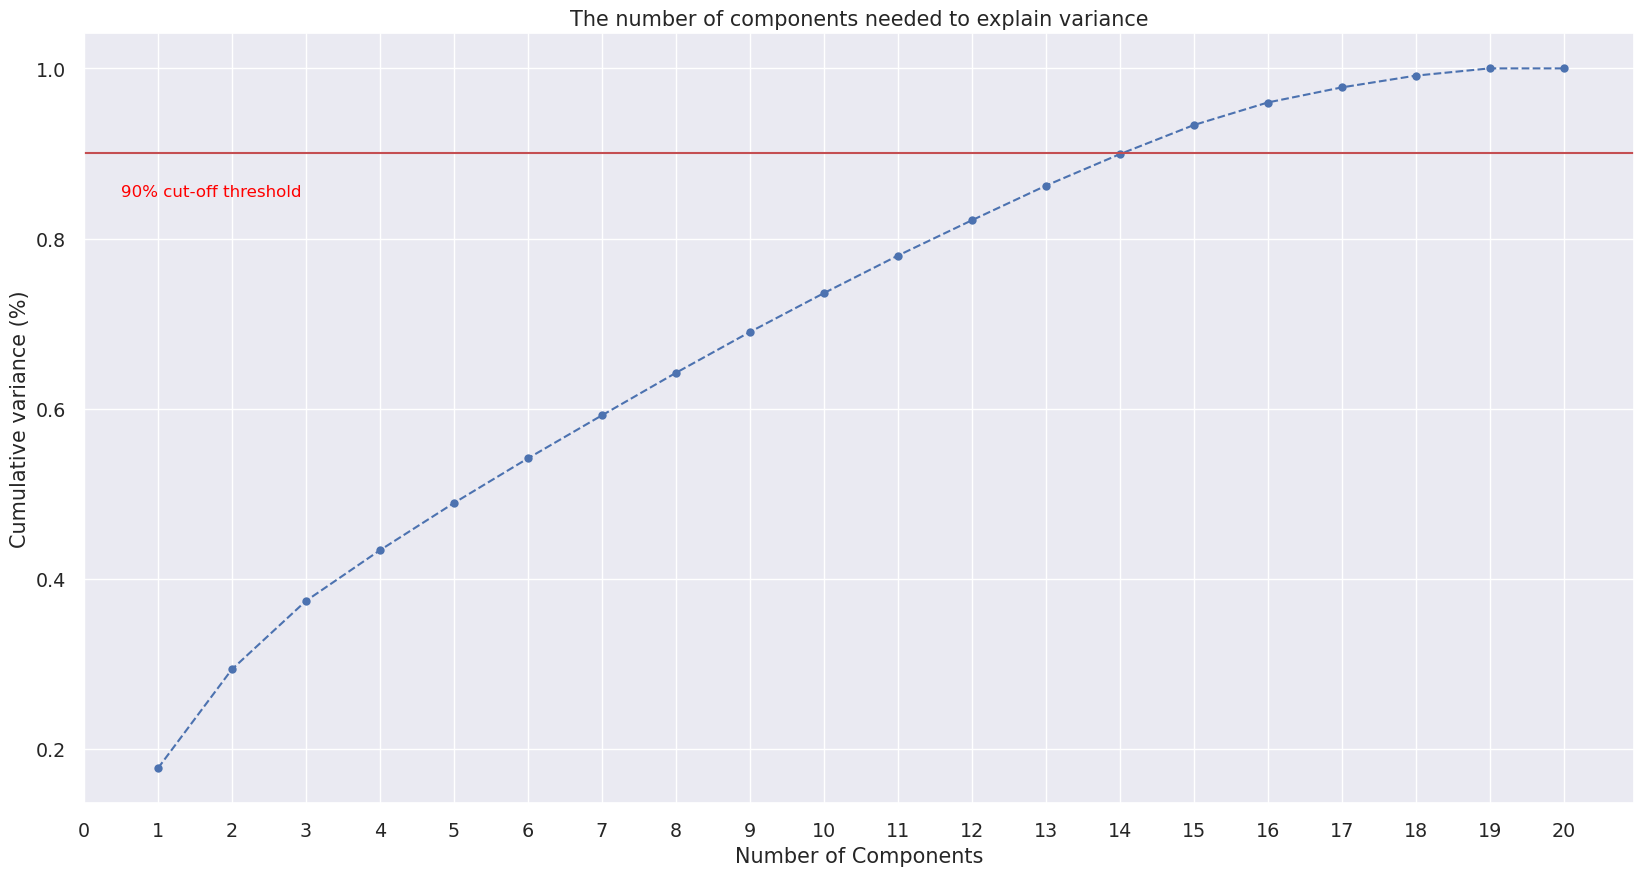

In [38]:
plt.figure(figsize=(20,10))

x = np.arange(1, len(df.columns)+1, step=1)
y = np.cumsum(pca.explained_variance_ratio_)

plt.plot(x, y, marker='o', linestyle='--', color='b')
plt.xlabel('Number of Components')
plt.xticks(np.arange(0, len(df.columns)+1, step=1))
plt.ylabel('Cumulative variance (%)')

plt.title('The number of components needed to explain variance')
plt.axhline(y=0.90, color='r', linestyle='-')
plt.text(0.5, 0.85, '90% cut-off threshold', color='red', fontsize=12)

plt.show()

In [39]:
scaled_df = pd.DataFrame(scaled_data, columns=df.columns)

In [40]:
# use PCA to project the data 
n_components = 14 # gives 90%
pca = PCA(n_components=n_components)  # Retain 90% of variance
reduced_data = pca.fit_transform(scaled_df)
reduced_data

array([[ 1.36177262,  0.72782714,  1.80447393, ..., -1.52095881,
        -0.58856412,  0.71727902],
       [-2.22667905,  2.24532505,  0.38181908, ..., -1.58882512,
         0.41498321,  0.81793197],
       [-0.38244366, -2.15111617, -0.33065143, ..., -0.01150406,
         0.37750205, -0.3576705 ],
       ...,
       [-0.53209513, -1.72173808,  0.87099115, ..., -0.82502406,
        -0.38856958,  0.47071613],
       [-0.86010826, -0.61481231,  0.69262536, ..., -0.67260885,
        -0.22206308,  1.28937819],
       [-0.292637  , -1.89972127, -0.73208808, ...,  0.13430264,
        -0.58492362, -0.58835968]])

In [41]:
top_components = pca.components_[:n_components]

# Calculate the absolute values of loadings and sort features by importance
feature_importance = np.abs(top_components).sum(axis=0)
sorted_feature_indices = np.argsort(feature_importance)[::-1]

# Select the top features
selected_feature_indices = sorted_feature_indices[:n_components]
selected_features = scaled_df.columns[selected_feature_indices]
selected_features

Index(['INCIDENT_REASON', 'OFFICER_AGE', 'SUBJECT_DETAILS.2', 'INCIDENT_YEAR',
       'SUBJECT_DETAILS', 'SUBJECT_GENDER', 'LOCATION_CITY',
       'INCIDENT_REASON.1', 'INCIDENT_MONTH', 'INCIDENT_DATE',
       'INCIDENT_WEEKDAY', 'LOCATION_DISTRICT', 'DISPOSITION',
       'LOCATION_DISTRICT.1'],
      dtype='object')

In [42]:
# creating dataframe for reduced data 
reduced_df = scaled_df[selected_features]
reduced_df.head()

,INCIDENT_REASON,OFFICER_AGE,SUBJECT_DETAILS.2,INCIDENT_YEAR,SUBJECT_DETAILS,SUBJECT_GENDER,LOCATION_CITY,INCIDENT_REASON.1,INCIDENT_MONTH,INCIDENT_DATE,INCIDENT_WEEKDAY,LOCATION_DISTRICT,DISPOSITION,LOCATION_DISTRICT.1
0,-1.058837,2.890849,0.216244,0.307059,0.544979,0.354917,0.839921,-1.246174,1.793542,-0.631461,-0.584947,-0.589854,2.494589,0.194748
1,0.669522,-0.375392,0.216244,-0.450486,-2.440129,0.354917,0.107426,-1.246174,-0.345863,0.955176,0.447464,-1.440042,-0.337778,-2.189834
2,0.093402,-1.167208,-1.338706,-0.450486,0.544979,0.354917,0.839921,-0.157904,-0.040234,-1.311448,-1.101152,0.260334,-0.337778,0.492821
3,-1.058837,-0.573346,0.216244,1.064603,0.544979,0.354917,-1.211063,-3.105302,-0.040234,0.615182,1.479874,-0.589854,1.361642,0.194748
4,-1.058837,3.979596,-0.302073,-1.965576,0.544979,0.354917,-1.211063,1.565190,1.793542,-1.538110,0.447464,-0.589854,-0.337778,0.194748


# Step 5: Cluster Analysis

### Choosing the Number of Clusters k

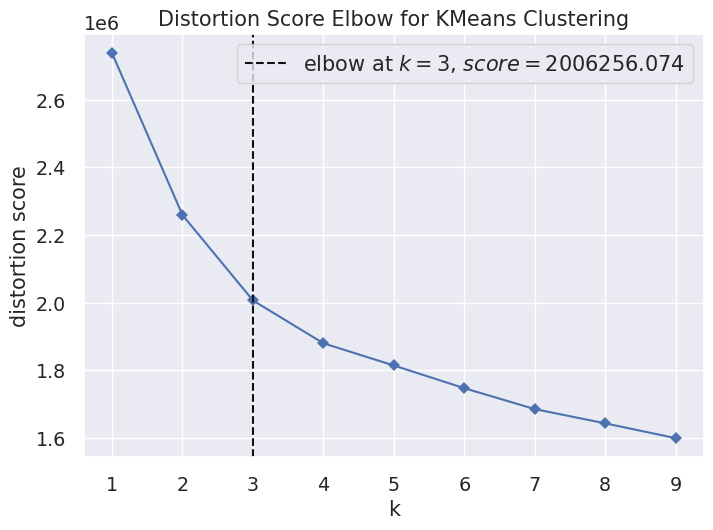

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [43]:
# create a k-Means model an Elbow-Visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1, 10), timings=False)
 
# fit the visualizer and show the plot
visualizer.fit(reduced_data)
visualizer.show()

### K-Means clustering

In [44]:
# clustering
kmeans = KMeans(n_clusters=3, random_state=0).fit(reduced_data)
 
# extract centroids of clusters into a dataframe
centers = kmeans.cluster_centers_
 
# extract cluster labels
cluster_assignments = kmeans.labels_

In [45]:
df.head()

,SUBJECT_GENDER,LOCATION_DISTRICT,LOCATION_DISTRICT.1,INCIDENT_DATE,SUBJECT_DETAILS,SUBJECT_RACE,SUBJECT_DETAILS.2,INCIDENT_REASON,INCIDENT_REASON.1,DISPOSITION,VEHICLE_MAKE,VEHICLE_YEAR,VEHICLE_COLOR,VEHICLE_DETAILS.1,OFFICER_RACE,OFFICER_AGE,LOCATION_CITY,INCIDENT_YEAR,INCIDENT_MONTH,INCIDENT_WEEKDAY
0,1,4,16,9,2,1,5,2,61,5,32,44,11,18,1,59,21,27,12,2
1,1,0,0,23,0,6,5,5,61,0,43,0,13,41,6,26,16,26,5,4
2,1,8,18,3,2,1,2,4,85,0,43,0,13,41,1,18,21,26,6,1
3,1,4,16,20,2,1,5,2,20,3,43,0,13,41,1,24,7,28,6,6
4,1,4,16,1,2,1,4,2,123,0,39,33,10,18,1,70,7,24,12,4


In [46]:
reduced_data.shape

(152230, 14)

In [47]:
# cor_mat = np.corrcoef(reduced_data)
# cor_mat

In [48]:
# cor_mat = np.corrcoef(reduced_data)

# plt.figure(figsize=(15, 7))
# sns.set(font_scale=0.6)
# mask = np.triu(np.ones_like(cor_mat, dtype=np.bool))
# ax = sns.heatmap(cor_mat, annot=True, fmt=".2g",
#                 annot_kws={'size': 'medium'}, linewidths=0.8, mask=mask)
# plt.show()